# Compare SVD analysis with PixelFLipping scores

### Imports

In [133]:
%load_ext autoreload
%autoreload 2

device = "cpu"
MNIST_CNN_PATH = './models/'
data_dir = "./dataset"
cat16_dir = data_dir + "/cat16"

import os
from tqdm import tqdm
import copy
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

import quantus

from util.util_cnn import CNNModel, data_loaders, test, \
                params_to_filename, params_from_filename, \
                load_mnist_v4_models, first_mnist_batch

from util.util_gamma_rule import \
                forw_surrogate_matrix,  \
                back_matrix, \
                global_conv_matrix_from_pytorch_layer, \
                calc_evals_batch, \
                calc_vals_batch, \
                plot_vals_lineplot, \
                smart_gamma_wo_sign_flips, \
                col_norms_for_matrices

from util.quantus import batch_auc, batch_mean_auc

from util.util_gamma_layers import GammaPerNeuronLayer, GammaWoSignFlipsLayer, Conv2dAsMatrixLayer

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_data_summary import *
import util.util_tutorial as tut_utils

from util.naming import *
from util.util_pickle import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load models

In [134]:
model = CNNModel().to(device)
model.load_state_dict(torch.load('./models/mnist_cnn_v4_cb1-16_cb2-32_seed-0.torch'))

<All keys matched successfully>

In [137]:
# load v4 models
model_dict = load_mnist_v4_models()

In [138]:
models_1 = {k:v for (k,v) in model_dict.items() if 'cb1-8' in k and 'seed-0' in k}

In [139]:
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']

### Load data

In [243]:
data, target = first_mnist_batch()

A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

### Forward pass, define LRP modes, LRP backward passes

In [360]:
# gamma_mode = 'cascading_gamma'
gamma_mode = 'individual_gamma'

gammas = gammas_0_1_21_inf
gammas = gammas40

modes = {0: 'LRP-0'}
for i, l_ub in enumerate(d3_after_conv_layer):
    for j, g in enumerate(gammas):
        if g=='inf': g = 1e8
        if g!=0:
            g = np.round(g, 8)
            if gamma_mode=='cascading_gamma':  modes[i*1000+j] = f'Gamma.            l<{l_ub} gamma={g}'
            if gamma_mode=='individual_gamma': modes[i*1000+j] = f'Gamma. l>{l_ub-2} l<{l_ub} gamma={g}'

if False: # recompute?
    relevancies_per_mode = {}
    for mode in tqdm(modes.values()):
        # if mode in relevancies_per_mode: continue
        rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
        if mode!="info": relevancies_per_mode[mode] = rels
    
    if   gammas is gammas40:          g_str = 'gammas40'
    elif gammas is gammas_0_1_21_inf: g_str = 'gammas_0_1_21_inf'
    else: assert 0

    save_data('d3', f'Rels__m0_to_0__{gamma_mode}__{g_str}', relevancies_per_mode)
else:
    assert (relevancies_per_mode := load_data('d3', f'Rels__m0_to_0__{gamma_mode}__{g_str}'))

In [326]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    elif type(index) is str:
        if index in modes.values():
            pass
        else:
            match = None
            for key in modes.values():
                if index in key:
                    assert match is None, f"Can not identify one unique mode with {index}: [{match}, {key}, ...]"
                    match = key

            assert match is not None, f"Can not identify any mode with {index}"
            index = match
    else: 
        raise "index must be of type str or numeric"
    return copy.deepcopy(relevancies_per_mode[index])

## Visualization

#### Visualization

In [149]:
layers_is = [6,5,3,2,0]
layers_is = [0]

shape: (1, 28, 28) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy 0.055674933


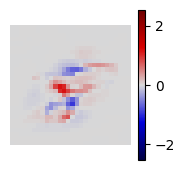

In [151]:
R = rel(0)

point_i = 0

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = np.array(R[l][point_i])
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean())
    tut_utils.heatmap(dat.sum(axis=0), 0.5*i+1.5, 0.5*i+1.5, colorbar=True)

#### Batched visualization

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0557, 0.0541, 0.0374, 0.0650, 0.0490, 0.0439])


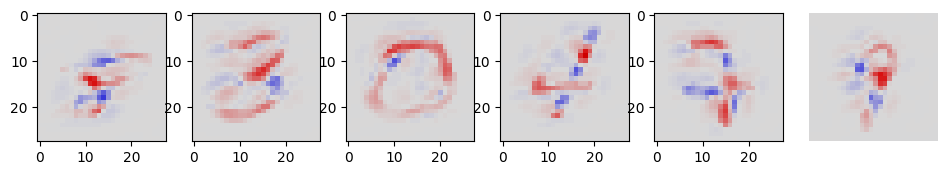

In [152]:
R = rel(0)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0540, 0.0529, 0.0367, 0.0631, 0.0479, 0.0429])


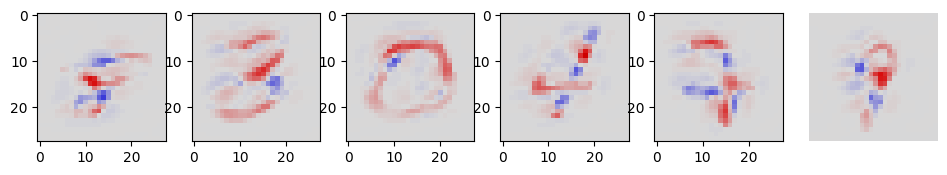

In [153]:
R = rel(1)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0158, 0.0134, 0.0080, 0.0187, 0.0119, 0.0117])


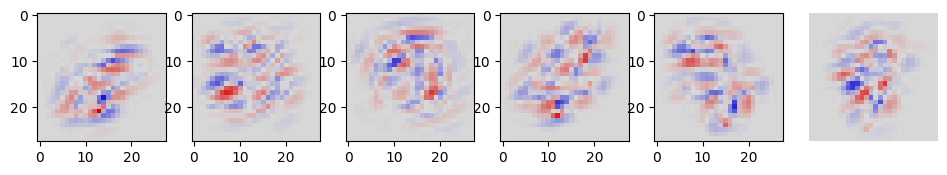

In [248]:
R1, R2 = rel('LRP-0'), rel('Gamma. l>1 l<3 gamma=1024.0')

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R1[l][:6] - R2[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

LRP-0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0557, 0.0541, 0.0374, 0.0650, 0.0490, 0.0439])


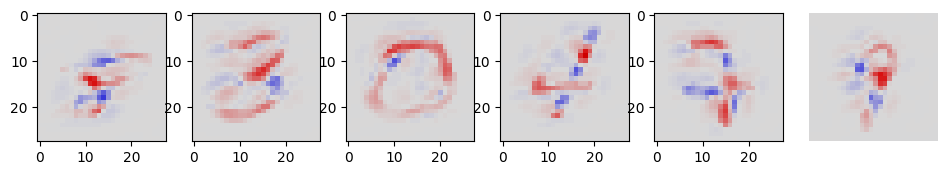

Gamma. l>1 l<3 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0458, 0.0451, 0.0329, 0.0526, 0.0419, 0.0376])


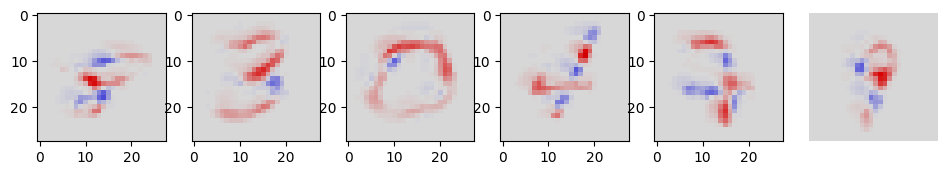

Gamma. l>3 l<5 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0279, 0.0385, 0.0281, 0.0374, 0.0335, 0.0276])


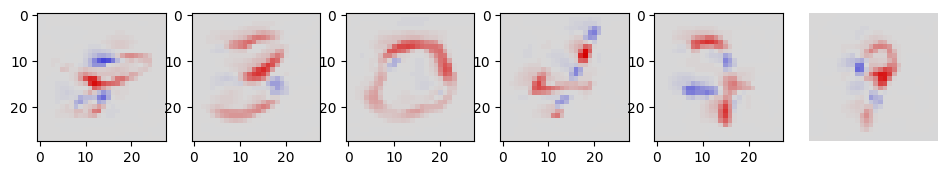

Gamma. l>6 l<8 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0167, 0.0326, 0.0259, 0.0225, 0.0206, 0.0194])


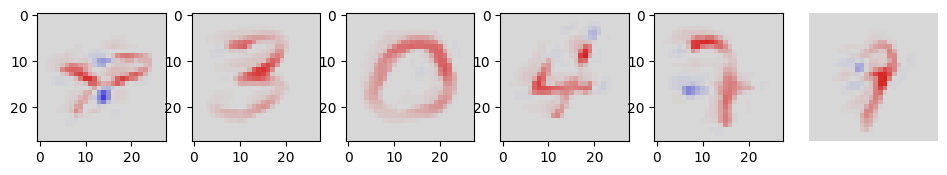

Gamma. l>8 l<10 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0214, 0.0364, 0.0278, 0.0263, 0.0204, 0.0194])


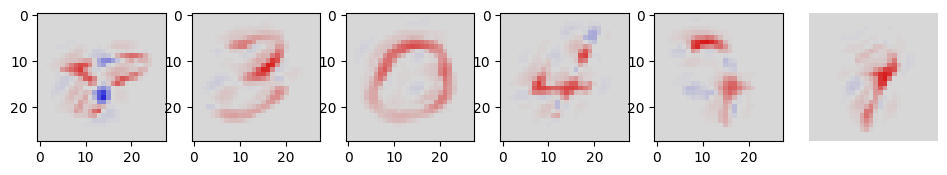

Gamma. l>10 l<12 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0216, 0.0390, 0.0298, 0.0282, 0.0209, 0.0221])


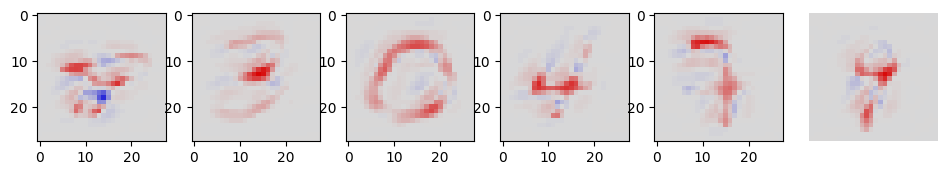

Gamma. l>14 l<16 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0249, 0.0450, 0.0369, 0.0361, 0.0260, 0.0282])


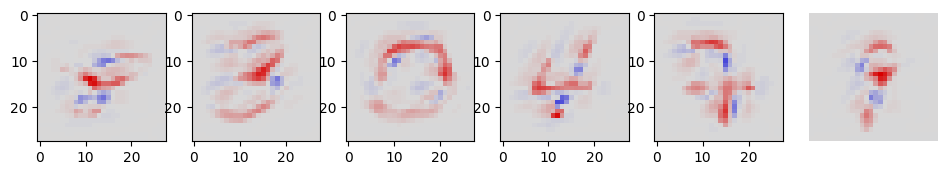

In [249]:
for mode in modes.values():
    if 'gamma=1024.0' not in mode and 'LRP-0' not in mode: continue
    print(mode)
    R = rel(mode)

    for i,l in enumerate(layers_is):
        if R[l] is None: continue
        dat = R[l][:6]
        print("shape:", dat.shape, "- before layer", l, ':', layers[l])
        print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
        tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

# Quantus Pixelflipping implementation

In [252]:
from quantus.helpers import utils
from copy import deepcopy

def batch_auc(batch):
    return [utils.calculate_auc(np.array(curve)) for curve in batch]
def batch_mean_auc(batch):
    return np.mean(batch_auc(batch))

In [361]:
k = None # num points = all
k = 4

y_batch = target.detach().numpy()
x_batch =   data.detach().numpy().reshape(a_batch.shape)

pixFlipMetric = quantus.PixelFlipping(disable_warnings = False, perturb_baseline='black')

def flipScores(a_batch, k=None):
    if k==None: k=len(a_batch)
    return pixFlipMetric(
        model=model,
        x_batch=x_batch[:k],
        y_batch=y_batch[:k],
        a_batch=a_batch[:k],
        device=device
    )

mode_list = sorted(modes.values())
# mode_list = ['LRP-0', 'Gamma. l<12 gamma=0.125', 'Gamma. l<12 gamma=0.25', 'Gamma. l<12 gamma=0.5', 'Gamma. l<12 gamma=inf']

### all in one
# batch_scores = { mode_str: { 'PixFlip': flipScores(rel(mode_str)[0].numpy(), k) } for mode_str in tqdm(mode_list) }
# save_data('d3', 'PixFlipScores_gammas40', batch_scores)

### partitioned
for i, mode_str in enumerate(mode_list):
    print(i, mode_str)
    model.eval()
    batch_scores = { mode_str: { 'PixFlip': flipScores(rel(mode_str)[0].numpy(), k) } }
    save_data('d3', 'PixFlipScores__individual_gamma__gammas40', batch_scores, partition=(0, i))

Warnings and information:
 (1) The Pixel Flipping metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bach, Sebastian, et al. 'On pixel-wise explanations for non-linear classifier decisions by layer - wise relevance propagation.' PloS one 10.7 (2015) e0130140.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.

0 Gamma. l>1 l<3 gamma=0.0001


/Users/jmaess/miniconda3/envs/msc/lib/python3.10/site-packages/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Saving: d3 PixFlipScores_gammas40__partition_000_000
1 Gamma. l>1 l<3 gamma=0.0003
Saving: d3 PixFlipScores_gammas40__partition_000_001
2 Gamma. l>1 l<3 gamma=0.001
Saving: d3 PixFlipScores_gammas40__partition_000_002
3 Gamma. l>1 l<3 gamma=0.0025
Saving: d3 PixFlipScores_gammas40__partition_000_003
4 Gamma. l>1 l<3 gamma=0.004
Saving: d3 PixFlipScores_gammas40__partition_000_004
5 Gamma. l>1 l<3 gamma=0.0055
Saving: d3 PixFlipScores_gammas40__partition_000_005
6 Gamma. l>1 l<3 gamma=0.007
Saving: d3 PixFlipScores_gammas40__partition_000_006
7 Gamma. l>1 l<3 gamma=0.0085
Saving: d3 PixFlipScores_gammas40__partition_000_007
8 Gamma. l>1 l<3 gamma=0.01
Saving: d3 PixFlipScores_gammas40__partition_000_008
9 Gamma. l>1 l<3 gamma=0.01666667
Saving: d3 PixFlipScores_gammas40__partition_000_009
10 Gamma. l>1 l<3 gamma=0.02333333
Saving: d3 PixFlipScores_gammas40__partition_000_010
11 Gamma. l>1 l<3 gamma=0.03
Saving: d3 PixFlipScores_gammas40__partition_000_011
12 Gamma. l>1 l<3 gamma=0.03666

In [354]:
relevancies_per_mode

False

In [349]:
mode_list

['LRP-0',
 'Gamma. l<12 gamma=0.125',
 'Gamma. l<12 gamma=0.25',
 'Gamma. l<12 gamma=0.5',
 'Gamma. l<12 gamma=inf']

In [224]:
# save_data('d3', 'PixFlipScores_gamma_0_1_21_inf', batch_scores)

### Load data and calculate statistics

In [363]:
if gammas is gammas_0_1_21_inf:
    print('gammas_0_1_21_inf')
    batch_scores = load_data('d3', 'PixFlipScores_gamma_0_1_21_inf')

    # unfortunately I made a mistake. The Pix Flip scores are computed wrt. the correct class "taget", but the explanations are for the predicted class "y_batch". Mask out those where this is not equal.
    correction_mask = (target.detach().numpy() == y_batch)
    print("Fraction of useful scores:", correction_mask.mean())
    
    corrected_scores={}
    for mode_str in tqdm(batch_scores.keys()):
        methods = list(batch_scores[mode_str].keys())
        for method in methods:
            corrected_scores[mode_str] = {}
            corrected_scores[mode_str][method] = np.array(batch_scores[mode_str][method])[correction_mask]

    # delete LRP-0 duplicates
    

    batch_scores = corrected_scores

elif gammas is gammas40:
    print('gammas40')
    batch_scores = load_data('d3', 'PixFlipScores_gammas40', partitioned=True)

batch_scores.keys(), next(iter(batch_scores.values())).keys()

gammas40


(dict_keys(['Gamma. l>1 l<3 gamma=0.0001', 'Gamma. l>1 l<3 gamma=0.0003', 'Gamma. l>1 l<3 gamma=0.001', 'Gamma. l>1 l<3 gamma=0.0025', 'Gamma. l>1 l<3 gamma=0.004', 'Gamma. l>1 l<3 gamma=0.0055', 'Gamma. l>1 l<3 gamma=0.007', 'Gamma. l>1 l<3 gamma=0.0085', 'Gamma. l>1 l<3 gamma=0.01', 'Gamma. l>1 l<3 gamma=0.01666667', 'Gamma. l>1 l<3 gamma=0.02333333', 'Gamma. l>1 l<3 gamma=0.03', 'Gamma. l>1 l<3 gamma=0.03666667', 'Gamma. l>1 l<3 gamma=0.04333333', 'Gamma. l>1 l<3 gamma=0.05', 'Gamma. l>1 l<3 gamma=0.075', 'Gamma. l>1 l<3 gamma=0.1', 'Gamma. l>1 l<3 gamma=0.125', 'Gamma. l>1 l<3 gamma=0.15', 'Gamma. l>1 l<3 gamma=0.175', 'Gamma. l>1 l<3 gamma=0.2', 'Gamma. l>1 l<3 gamma=0.33333333', 'Gamma. l>1 l<3 gamma=0.46666667', 'Gamma. l>1 l<3 gamma=0.6', 'Gamma. l>1 l<3 gamma=0.73333333', 'Gamma. l>1 l<3 gamma=0.86666667', 'Gamma. l>1 l<3 gamma=1.0', 'Gamma. l>1 l<3 gamma=1024.0', 'Gamma. l>1 l<3 gamma=128.0', 'Gamma. l>1 l<3 gamma=16.0', 'Gamma. l>1 l<3 gamma=1e-05', 'Gamma. l>1 l<3 gamma=2.0

In [335]:
# ### calc AUC

# experiment_dict = {}

# for mode_str, mode_dict in batch_scores.items():
#     experiment_dict[mode_str] = {}
#     for method_str, method_scores in mode_dict.items():
#         if 'AUC' in method_str: continue
#         experiment_dict[mode_str][method_str + ' AUC (per sample)'] =      batch_auc(method_scores)
#         experiment_dict[mode_str][method_str + ' AUC (batch mean)'] = batch_mean_auc(method_scores)

#     # experiment_dict[mode_str]['Layerwise Relevancies'] = relevancies_per_mode[mode_str]
    
# experiment_dict['x_batch'] = x_batch
# experiment_dict['y_batch'] = y_batch


# ### prep plotting

# k = len(next(iter(experiment_dict.values()))['PixFlip AUC (per sample)'])

# aucs =      np.zeros((len(d3_after_conv_layer), k, len(gammas), 1))
# auc_means = np.zeros((len(d3_after_conv_layer), 1, len(gammas), 1))

# for i, l_ub in enumerate(d3_after_conv_layer):
#     for j, g in enumerate(gammas):
#         if g!=0:
#             mode_str = f'Gamma. l<{l_ub} gamma={g}'
#         else: 
#             mode_str = 'LRP-0'
            
#         if mode_str not in experiment_dict.keys(): continue
        
#         aucs[i, :, j, 0] = experiment_dict[mode_str]['PixFlip AUC (per sample)']
#         auc_means[i, 0, j, 0] = experiment_dict[mode_str]['PixFlip AUC (batch mean)']

# print(aucs.shape, auc_means.shape)
# experiment_dict.keys(), next(iter(experiment_dict.values())).keys()

In [340]:
batch_scores.keys()

dict_keys(['Gamma. l>1 l<3 gamma=0.0001', 'Gamma. l>1 l<3 gamma=0.0003', 'Gamma. l>1 l<3 gamma=0.001', 'Gamma. l>1 l<3 gamma=0.0025'])

In [338]:
### calc AUC

experiment_dict = {}

for mode_str, mode_dict in batch_scores.items():
    experiment_dict[mode_str] = {}
    for method_str, method_scores in mode_dict.items():
        if 'AUC' in method_str: continue
        experiment_dict[mode_str][method_str + ' AUC (per sample)'] =      batch_auc(method_scores)
        experiment_dict[mode_str][method_str + ' AUC (batch mean)'] = batch_mean_auc(method_scores)

    # experiment_dict[mode_str]['Layerwise Relevancies'] = relevancies_per_mode[mode_str]
    
experiment_dict['x_batch'] = x_batch
experiment_dict['y_batch'] = y_batch


### prep plotting

k = len(next(iter(experiment_dict.values()))['PixFlip AUC (per sample)'])

aucs =      np.zeros((len(d3_after_conv_layer), k, len(gammas), 1))
auc_means = np.zeros((len(d3_after_conv_layer), 1, len(gammas), 1))

l_keys = []
for key in experiment_dict.keys():
    if 'Gamma.' in key:
        key = key.split('gamma=')[0]
        if key not in l_keys:
            l_keys.append(key)

for i, l_key in enumerate(l_keys):
    mode_strs=[]
    if 0 in gammas: mode_strs.append('LRP-0')
    for mode_str in experiment_dict.keys():
        if l_key in mode_str: mode_strs.append(mode_str)

    for j, mode_str in enumerate(mode_strs):
        aucs[i, :, j, 0] =      experiment_dict[mode_str]['PixFlip AUC (per sample)']
        auc_means[i, 0, j, 0] = experiment_dict[mode_str]['PixFlip AUC (batch mean)']

print(aucs.shape, auc_means.shape)

KeyError: 'LRP-0'

In [333]:
experiment_dict.keys()

dict_keys(['Gamma. l>1 l<3 gamma=0.0001', 'Gamma. l>1 l<3 gamma=0.0003', 'Gamma. l>1 l<3 gamma=0.001', 'Gamma. l>1 l<3 gamma=0.0025', 'x_batch', 'y_batch'])

In [320]:
l_keys = []
for key in experiment_dict.keys():
    if 'Gamma.' in key:
        key = key.split('gamma=')[0]
        if key not in l_keys:
            l_keys.append(key)

### Plot PixFlip performance

(<Figure size 3000x300 with 6 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='AUC batch mean'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

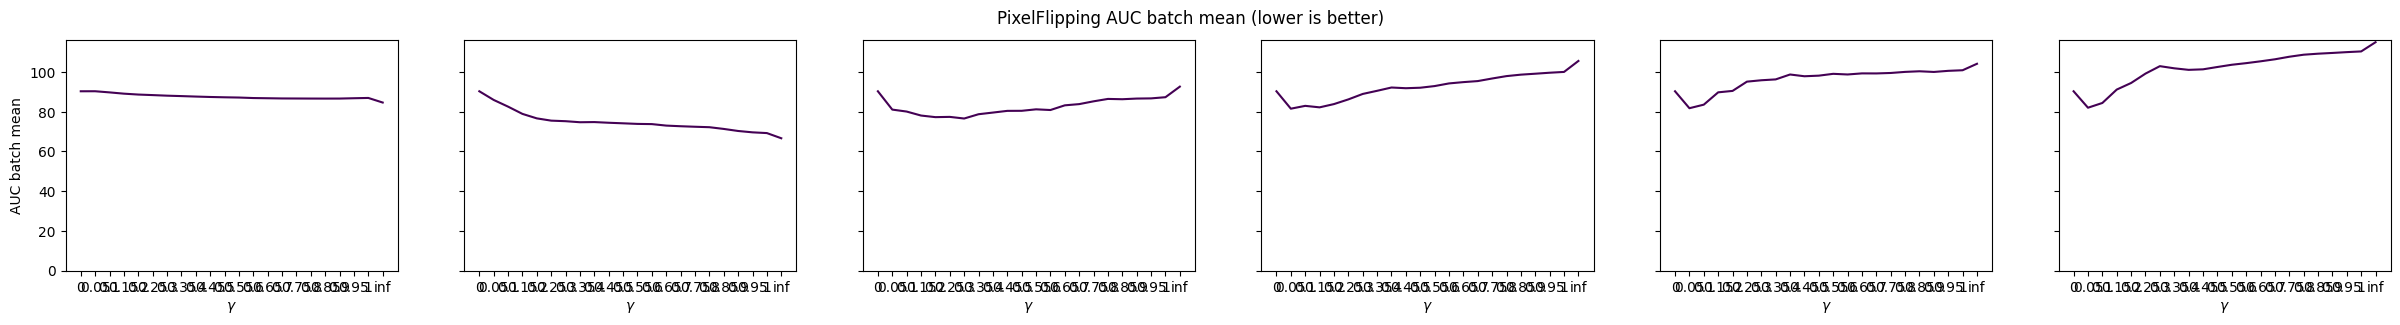

In [321]:
plot_vals_lineplot(auc_means, ylim=(0, auc_means.max()), 
                    ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True)

(<Figure size 3000x300 with 6 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='AUC batch mean'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

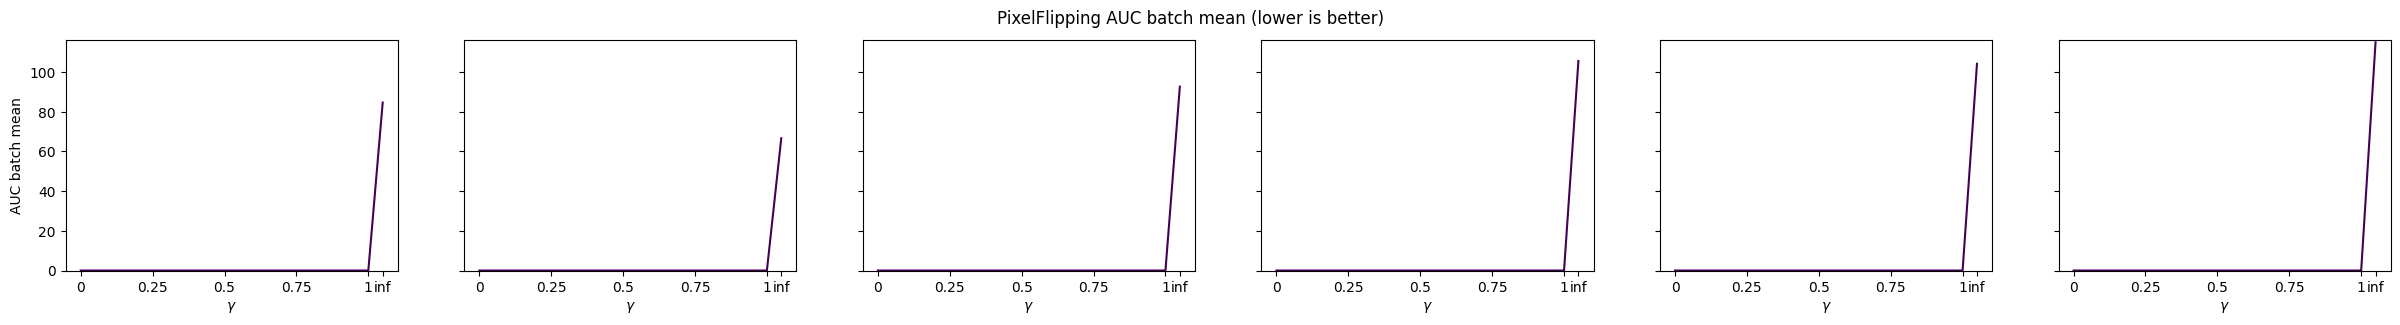

In [294]:
xtick_mask = np.zeros(len(gammas)).astype(bool)
xtick_mask[[0, 5, 10, 15, 20, -1]] = True

plot_vals_lineplot(auc_means, gammas, ylim=(0, auc_means.max()), ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True, xtick_mask=xtick_mask)

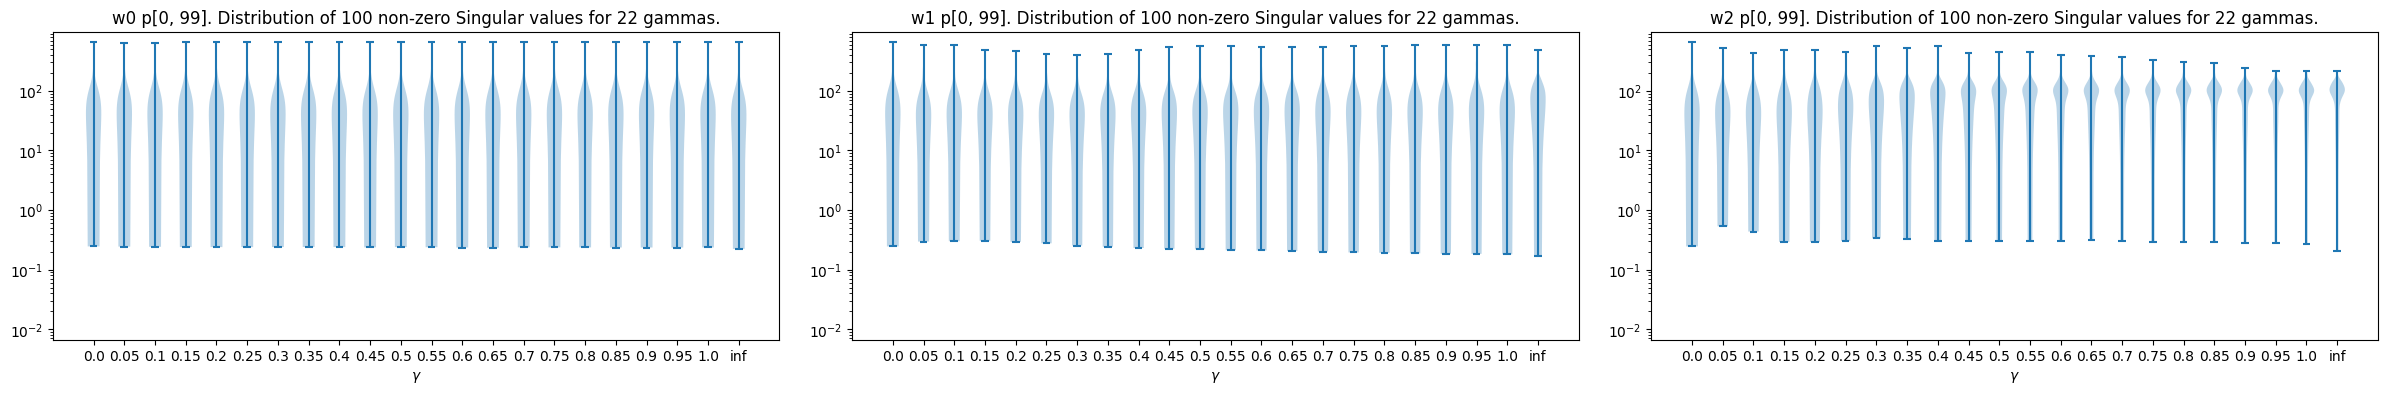

In [241]:
distribution_plot(aucs[[0,2,4]], gammas_0_1_21_inf, aggregate_over='points', mode='violin')

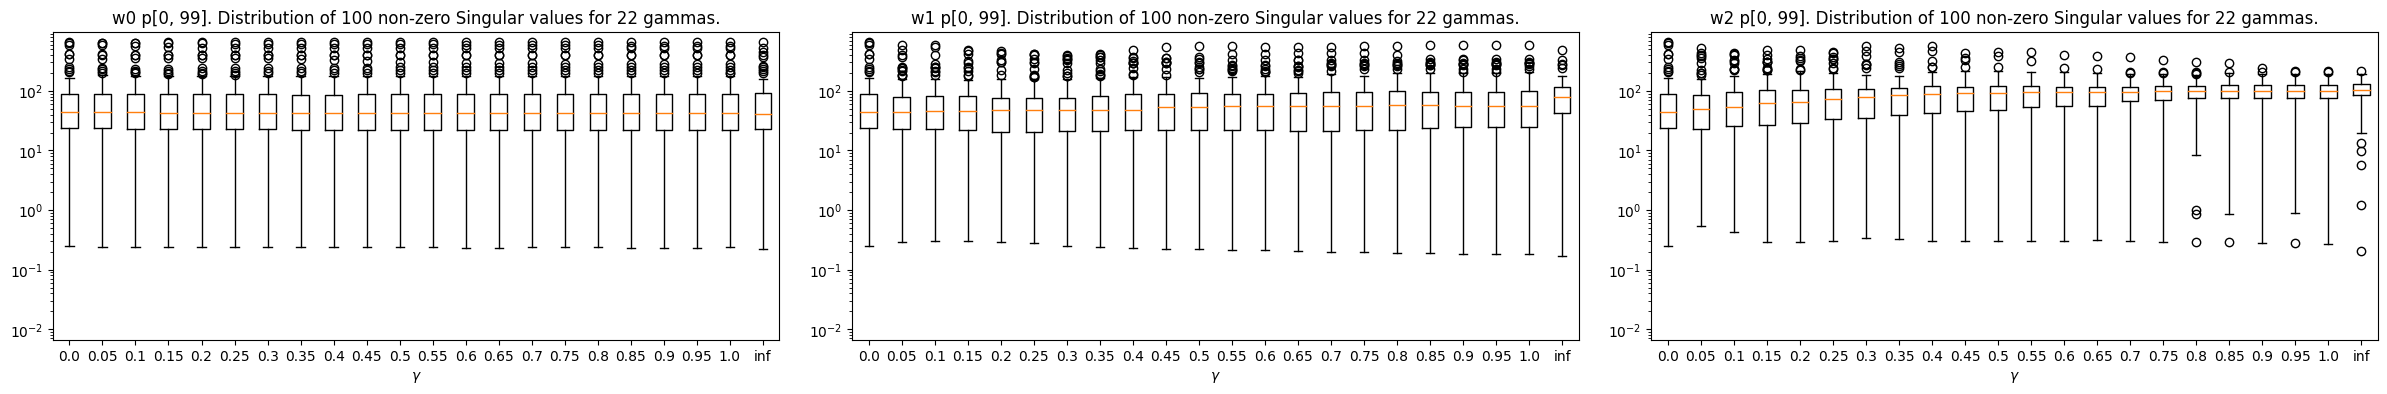

In [242]:
distribution_plot(aucs[[0,2,4]], gammas_0_1_21_inf, aggregate_over='points', mode='box')

### Plot individual PixFlipScores

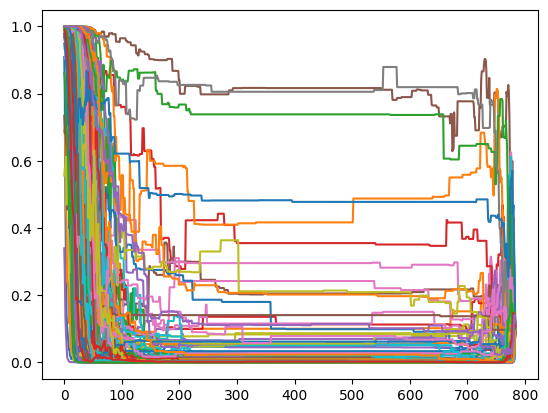

In [298]:
# pixel flip scores for LRP-0
scores = experiment_dict['LRP-0']['PixFlip']
scores = np.array(scores)
print(scores.shape)
plt.plot(scores.T);

(95, 784)


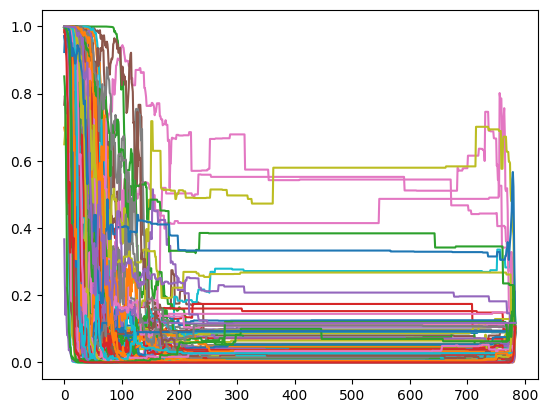

In [301]:
# pixel flip scores for Gamma. l<12 gamma=0.25
scores = experiment_dict['Gamma. l<12 gamma=0.25']['PixFlip']
scores = np.array(scores)
print(scores.shape)
plt.plot(scores.T);